# Plotting geometries

[Geometries](https://developers.arcgis.com/geoanalytics/core-concepts/geometry/) in ArcGIS GeoAnalytics Engine consist of points, lines, polygons and multipoints. Plotting geometries can help you visualize the shapes and better understand the spatial data you are working with. This notebook will introduce you to some of the ways you can use the plotting functionality that is built-in with ArcGIS GeoAnalytics Engine.

### Workflow overview
1. [Plot point data](#Plot-point-data)
2. Use matplotlib.pyplot [variable-length arguments](#Variable-length-arguments).
3. Use matplotlib.cm [colormaps](#Colormaps) for categorical and continuous data.
5. [Plot line data](#Plot-line-data)
6. [Plot columns of more than one geometry type](#Plot-columns-of-more-than-one-geometry-type)
7. [Plot multiple axes on the same figure](#Plot-multiple-axes-on-the-same-figure)
8. [Plot polygon data](#Plot-polygon-data)
9. [Additional plotting tutorials and topics](#Additional-plotting-tutorials-and-topics)

In [1]:
# Import the modules and functions and authorize geoanalytics
import geoanalytics
from geoanalytics.sql import functions as ST, Point
from pyspark.sql import functions as F

geoanalytics.auth(username="username", password="password")

## Plot point data

In [2]:
# Create a DataFrame with point data
points_wkt = [(0, Point(0, 0), "blue"), 
              (1, Point(0, 5), "red"), 
              (2, Point(5, 5), "green"), 
              (3, Point(5, 0), "blue"), 
              (4, Point(2.5, 2.5), "yellow")
             ]

points_df = spark.createDataFrame(points_wkt, ["id", "point", "color"])
points_df.show(truncate=False)

+---+-----------------+------+
|id |point            |color |
+---+-----------------+------+
|0  |{"x":0,"y":0}    |blue  |
|1  |{"x":0,"y":5}    |red   |
|2  |{"x":5,"y":5}    |green |
|3  |{"x":5,"y":0}    |blue  |
|4  |{"x":2.5,"y":2.5}|yellow|
+---+-----------------+------+



Calling `df.st.plot()` will plot the geometries in the DataFrame given that the column containing the geometries is named "geometry". If you would like to specify a specific column to plot, call `df.st.plot(geometry=["GEOM_COLUMN_NAME"]`

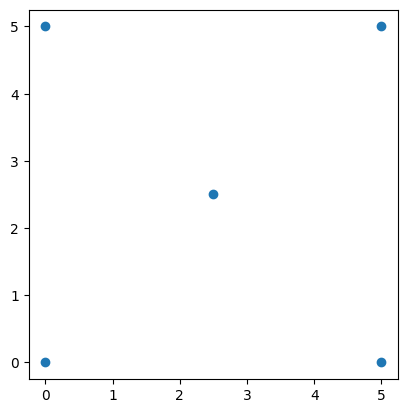

In [3]:
# Needed to make the plots appear in the notebook
%matplotlib inline

points_df.st.plot();

#### Variable-length arguments

The `plot()` function leverages matplotlib.pyplot and is passed similar arguments to customize the plotted figure. Here is an example of the how to control the aspect, markersize, marker and color of the plot above. A full list of possible values for `plot()`'s variable-length arguments can be found in [matplotlib's documentation](https://matplotlib.org/stable/api/).

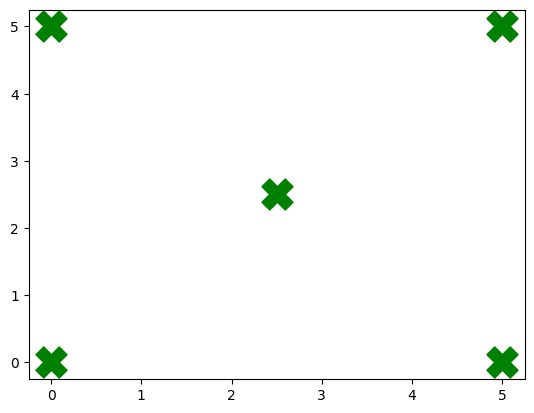

In [4]:
points_df.st.plot(aspect="auto", s=500, marker="X", color="green");

#### Colormaps

Commonly, you'll want to plot data color-coded by a specific attribute. This is known as a "color mapping". The attribute may either be continuous or categorical. One way to plot data based on a category is to manually assign a specific color for every category and pass this column to the `cmap_values` argument.

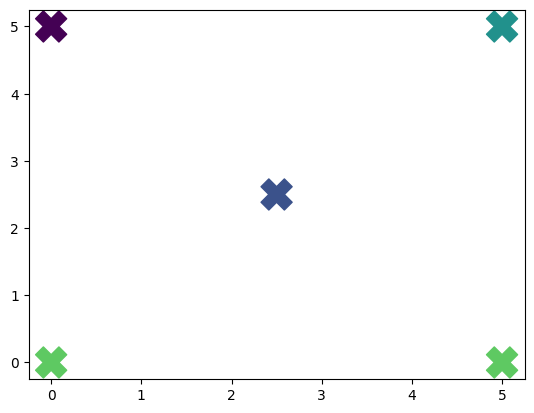

In [5]:
ax = points_df.st.plot(cmap_values="color", aspect="auto", s=500, marker="X")

A better way is to let matplotlib's built-in [colormapping](https://matplotlib.org/stable/tutorials/colors/colormaps.html) do this for you. First, create a DataFrame with a multipoint geometry column and a category column. Matplotlib's cmap can handle both categorical data and continuous data. 
- For categorical data, cmap needs it to be encoded in numerical form in order to apply the colormapping. To encode the categorical data, add the id column which has a one-to-one mapping with the category column. To distinguish between categorical mapping and continuous mapping select a colormap that has qualitative colors and pass discrete values to the cmap_values. 
- To map continuous data, pass continuous values to the `cmap_values` and choose a colormapping that is sequential.

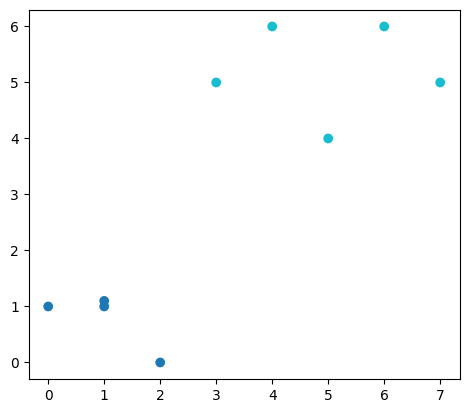

In [6]:
# Color mapping categorical data
mpoints_wkt = [(0, "MULTIPOINT(0 1, 1 1, 1 1.1, 2 0)", "A"), (1, "MULTIPOINT(5 4, 4 6, 7 5, 3 5, 6 6)", "B")]
mpoints = spark.createDataFrame(mpoints_wkt).toDF("id", "wkt", "category")\
    .withColumn("geometry", ST.mpoint_from_text("wkt")).drop("wkt")
mpoints.st.plot(cmap="tab10", cmap_values="id");

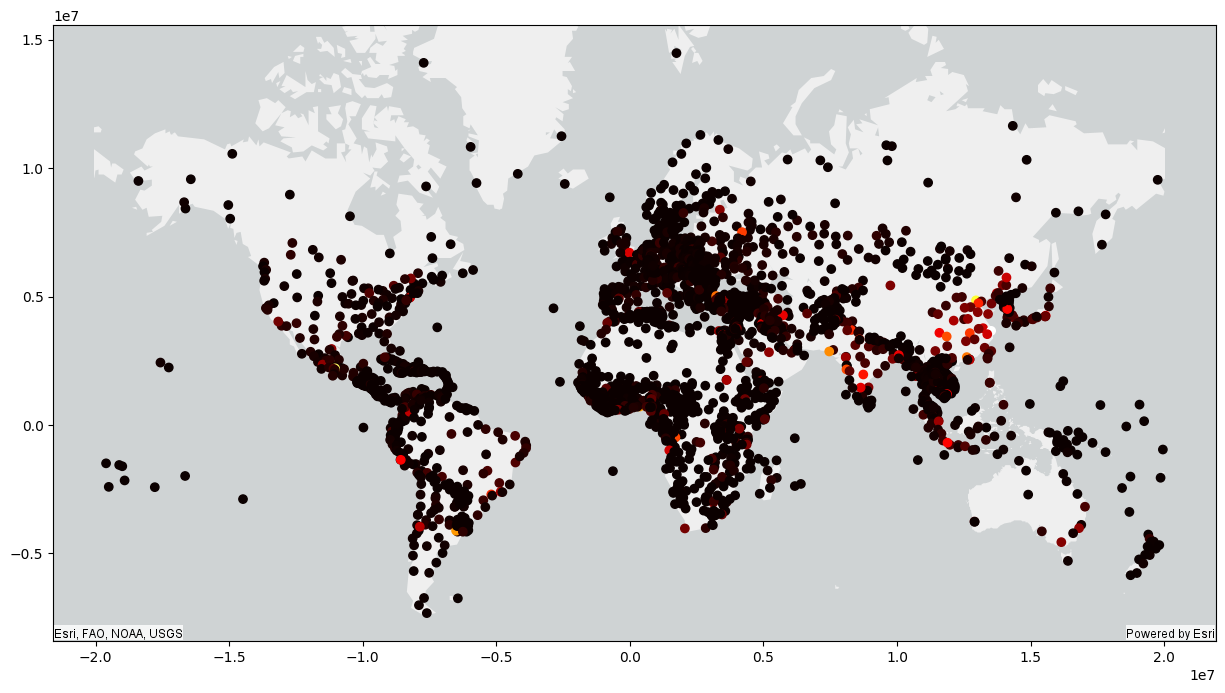

In [7]:
# Color mapping continuous data (world city populations)
cities_FS ="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Cities/FeatureServer/0"
cities = spark.read.format('feature-service').load(cities_FS)
cities.st.plot(figsize=(15,8), cmap_values="POP", cmap="hot", aspect="auto", basemap="light");

## Plot line data
ArcGIS GeoAnalytics Engine can plot more than just points. Here is an example of how to plot linestrings and set the edgecolor. 

+---+-------------------------------------------+
|id |geometry                                   |
+---+-------------------------------------------+
|0  |{"paths":[[[1,5],[0,5],[0,4],[1,4]]]}      |
|1  |{"paths":[[[2,4],[2,5],[3,5],[3,4],[2,4]]]}|
|2  |{"paths":[[[4,4],[4,5],[5,5],[5,4],[4,4]]]}|
|1  |{"paths":[[[6,5],[6,4],[7,4]]]}            |
+---+-------------------------------------------+



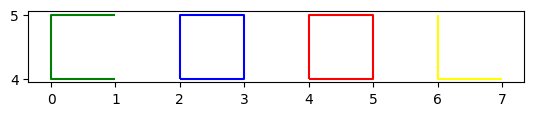

In [8]:
lines_wkt = [(0, "LINESTRING (1 5, 0 5, 0 4, 1 4)"), 
             (1, "LINESTRING (2 4, 2 5, 3 5, 3 4, 2 4)"), 
             (2, "LINESTRING (4 4, 4 5, 5 5, 5 4, 4 4)"), 
             (1, "LINESTRING (6 5, 6 4, 7 4)")]
lines_wkt_df = spark.createDataFrame(lines_wkt).toDF("id", "wkt")
lines_df = lines_wkt_df.withColumn("geometry", ST.line_from_text("wkt")).select("id", "geometry").cache()

lines_df.show(truncate=False)
lines_df.st.plot(edgecolor=["green", "blue", "red", "yellow"]);

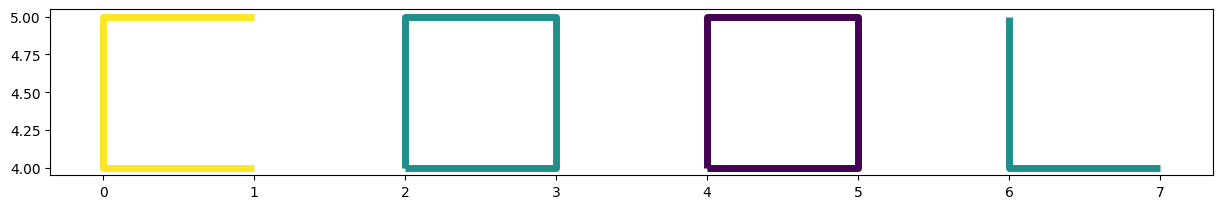

In [9]:
# Use the id column for discrete color mapping, setting figsize and linewidth
lines_df.st.plot(cmap_values="id", cmap="viridis_r", figsize=(15,10), linewidth=5);

## Plot columns of more than one geometry type
ArcGIS GeoAnalytics Engine can also plot geometries of different types in the same plot. For example, polygons and points. Note how manually assigning the color applies to all geometries in the plot. 

In [10]:
unk_points_df = points_df.withColumn("mixed_geometry", ST.cast("point", "geometry")).select("mixed_geometry")
unk_lines_df = lines_df.withColumn("mixed_geometry", ST.cast("geometry", "geometry")).select("mixed_geometry")
geometries_df = unk_points_df.union(unk_lines_df)

geometries_df.printSchema()
geometries_df.show(truncate=False)

root
 |-- mixed_geometry: geometry (nullable = true)

+-------------------------------------------+
|mixed_geometry                             |
+-------------------------------------------+
|{"x":0,"y":0}                              |
|{"x":0,"y":5}                              |
|{"x":5,"y":5}                              |
|{"x":5,"y":0}                              |
|{"x":2.5,"y":2.5}                          |
|{"paths":[[[1,5],[0,5],[0,4],[1,4]]]}      |
|{"paths":[[[2,4],[2,5],[3,5],[3,4],[2,4]]]}|
|{"paths":[[[4,4],[4,5],[5,5],[5,4],[4,4]]]}|
|{"paths":[[[6,5],[6,4],[7,4]]]}            |
+-------------------------------------------+



<AxesSubplot: >

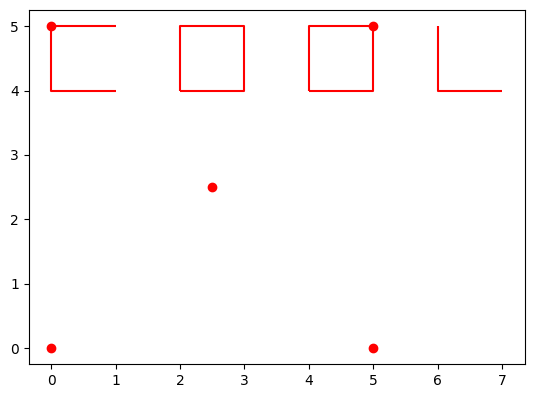

In [11]:
# Plot linestrings and points together
geometries_df.st.plot(color="red")

#### Plot multiple axes on the same figure

ArcGIS GeoAnalytics Engine plots return the matplotlib axes. You can pass these axes to another plot to overlay different geometry columns in the same plot. There's a lot you can do with the [axes](https://matplotlib.org/stable/api/axes_api.html), such as setting the title and x and y labels. Note: Adding a semicolon to the last axes expression prevents matplotlib descriptions from displaying in Jupyter Notebooks.

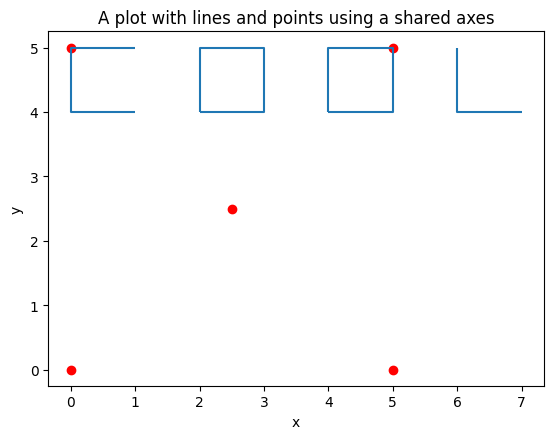

In [12]:
# Example using the axes argument
lines_ax = lines_df.st.plot()
points_ax = points_df.st.plot(ax=lines_ax, color="red")
points_ax.set_xlabel("x")
points_ax.set_ylabel("y")
points_ax.set_title("A plot with lines and points using a shared axes");

## Plot polygon data

+--------------------------------------------------------------------------------------------------------------------------------+------+
|geometry                                                                                                                        |values|
+--------------------------------------------------------------------------------------------------------------------------------+------+
|{"rings":[[[0,0],[0,10],[10,10],[10,0],[0,0]]]}                                                                                 |0     |
|{"rings":[[[40,40],[45,30],[20,45],[40,40]],[[20,35],[45,20],[30,5],[10,10],[10,30],[20,35]],[[30,20],[20,25],[20,15],[30,20]]]}|3     |
+--------------------------------------------------------------------------------------------------------------------------------+------+



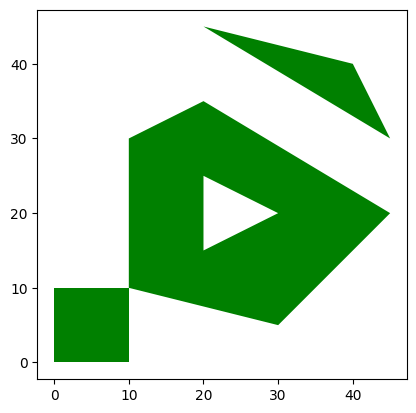

In [13]:
# Plot polygons example
poly_wkt = [
    (0, "POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))"),
    (3, "MULTIPOLYGON (((40 40, 20 45, 45 30, 40 40)),((20 35, 10 30, 10 10, 30 5, 45 20, 20 35),(30 20, 20 15, 20 25, 30 20)))")
]

poly_wkt_df = spark.createDataFrame(poly_wkt).toDF("values", "wkt")
poly_df = poly_wkt_df.withColumn("geometry", ST.poly_from_text("wkt")).select("geometry","values").cache()
poly_df.show(truncate=False)
poly_df.st.plot(facecolors="green");

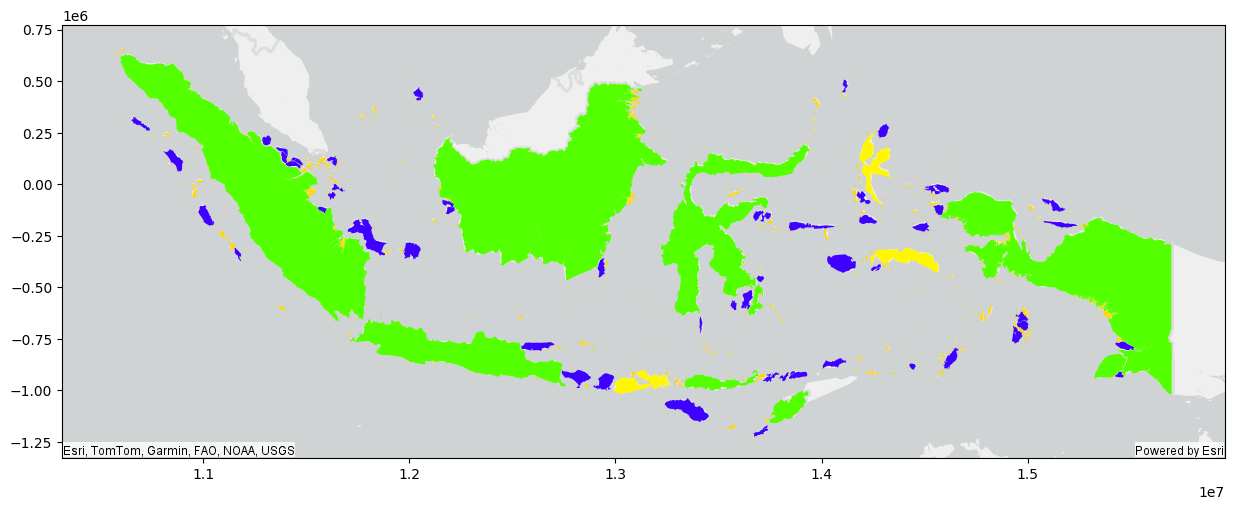

In [14]:
# Example of plotting world countries, filtering by country and coloring by land area
countries_FS ="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Countries/FeatureServer/0"
countries = spark.read.format('feature-service').load(countries_FS)

countries.where(F.col("COUNTRY") == "Indonesia").st.plot(cmap_values="Shape__Area", cmap="prism", figsize=(15,8), basemap="light");

## Additional plotting tutorials and topics

In summary, this notebook shows you how to plot different geometry types and some plotting parameters. You can learn more about plotting in the following tutorials and topics:

 - [Visualize results](https://next.sites.afd.arcgis.com/geoanalytics/core-concepts/visualize-results/)
 - [Visualize results with st.plot()](https://next.sites.afd.arcgis.com/geoanalytics/tutorials/visualize/visualize-results-st-plot/)
  